Projektinlämning del 1 - Beskrivning av problem

1. Klassificeringsproblem.
Många som hyr sin bostad undrar om de betalar för mycket i hyra för sin bostad. För att få veta om de betalar mycket eller lite i hyra jämfört med liknande hyresbostäder låter vi maskin inlärning läsa in och processa data gällande genomsnittshyror för hyresrätter 2022-2024 för hela riket. Datan kommer från Skatteverket. Baserat på datan låter vi maskinen besluta om den nuvarande hyran är mycket låg, låg, medelhög, hög eller mycket hög beroende på bostadens värdeår. 

(Då den ansvarige för Skatteverkets CSV-fil är på semester och dokumentation för filen saknas så kan tyvärr inte hänsyn tas till värdeområdes-numrena. Dessa skulle idealt ha mappats till ett område och tagits hänsyn till i förutsägelsen om hyrans storlek.)

Indata
Månadshyra
Antal kvadratmeter
Värdeår

Vi gör detta till ett klassifficeringsproblem där vi vill få ut en hyresnivå tillhörande en av kategorierna
Mycket låg
Låg
Medel
Hög
Mycket hög

2. Klassificeringsproblem.
Om användaren vill veta vilket värdeår bostaden bör tillhöra, beroende på hyresnivån och antalet kvadratmeter bostaden är, kan denne göra detta genom att sätta värdeåret till None.
Om angiven bostad får en hyra med medelhög nivå för något värdeår används detta värdeår. Om flera värdeår matchar hyran ges det äldsta värdeåret som sannolikt värdeår, för att inte göra användaren besviken i onödan.

Input från användaren, hårdkodat i koden nedanför då input inte funkade in notebooks av någon anledning:
Månadshyra
Antal kvadratmeter

Utdata
Värdeår

Beskrivning av datan i Skatteverkets CSV-fil
Värdeår_XYZW är fastighetens värdeår, vilket normalt sett innebär det år då fastigheten färdigställdes.
Talen är kr/(år och kvm) i hyra

Antag att vi har intervallen för hyror
Lägsta 10 % innebär mycket låg hyra
10-35% innebär låg hyra 
35-65% innebär medelhög hyra
65-90% innebär hög hyra
90-100% innebär mycket hög hyra

In [103]:
ranges = [10, 35, 65, 90]
rentLevels = ['Mycket låg', 'Låg', 'Medelhög', 'Hög', 'Mycket hög']

In [2]:
import pandas
import numpy as np

skvData = pandas.read_csv('Data/SKV_Genomsnittshyra_bostad_2022-2024.csv')

# Kolla om datan innehåller null. Allt ska vara tal. Det ser ut att bara vara tal när jag tittar på datan, men låt oss verifiera för säkerhets skull
print(skvData.shape)
data = np.array(skvData)

for row in data:
    for col in row:
        if(col is None):
            print(f'{row}, {col}')

(1954, 17)


C:\Users\annaa\AppData\Local\Temp\ipykernel_19556\3846250130.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


Konklusion: Där är inga värden i datan som är None i alla fall.
Nästa steg: Kolla om där finns extrem-värden (outliers) som ska tas bort före modellen tränas

# ANTR TO DO, PLOT MED SCATTERPLOT FÖR RESPEKTIVE VALUEYEAR

AttributeError: 'list' object has no attribute 'loc'

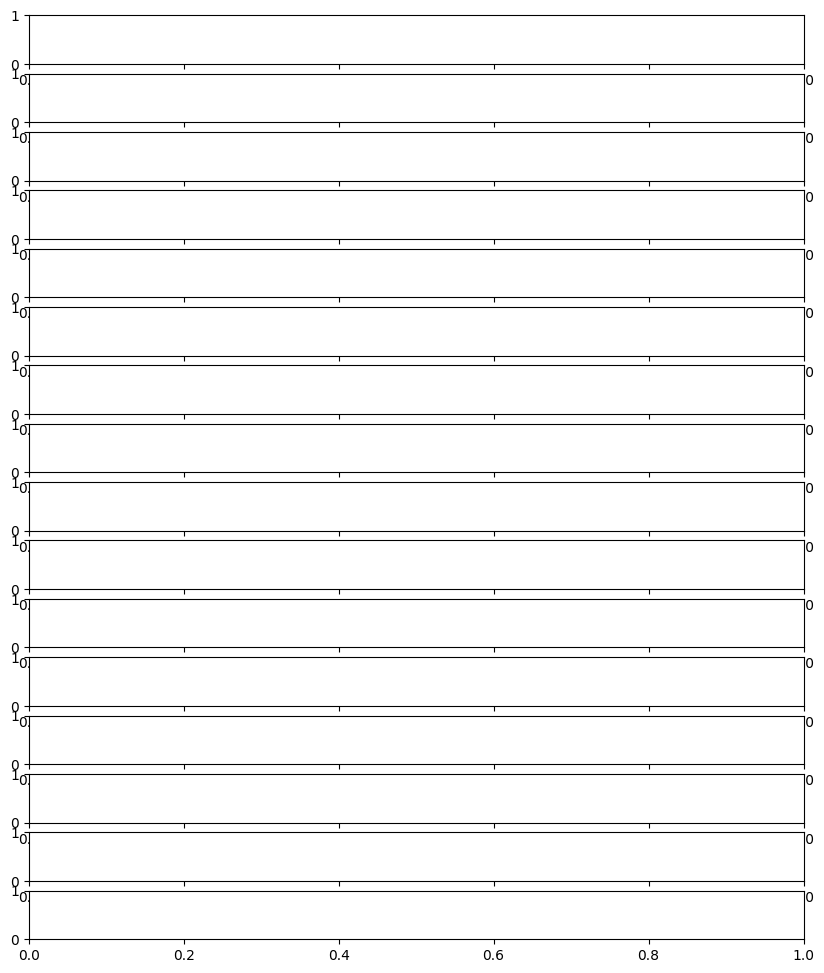

In [22]:
# import matplotlib.pyplot as plt
# import pandas
# import numpy as np

# # # Match rent-level to a color
# # colors = {
# #     1929: 'blue',
# #     1930: 'green',
# #     1940: 'yellow',
# #     1950: 'orange',
# #     1960: 'red',
# #     1970: 'magenta',
# #     1980: 'blue',
# #     1990: 'green',
# #     1995: 'yellow',
# #     1998: 'orange',
# #     2001: 'red',
# #     2004: 'magenta',
# #     2007: 'blue',
# #     2010: 'green',
# #     2013: 'yellow',
# #     2016: 'orange',
# #     2019: 'red'
# # }

# skvData = pandas.read_csv('Data/SKV_Genomsnittshyra_bostad_2022-2024.csv')

# rent = "Hyra"
# valueYears = [1929, 1930, 1950, 1960, 1970, 1980, 1990, 1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019]

# def GetRentPerYearPerSqmColumn(builtYear, X):
#     if(builtYear <= 1929):
#         return skvData['vardear 1929']
#     elif(builtYear >= 1930 and builtYear < 1950):
#         return skvData['vardear 1930']
#     elif(builtYear >= 1950 and builtYear < 1960):
#         return skvData['vardear 1950']
#     elif(builtYear >= 1960 and builtYear < 1970):
#         return skvData['vardear 1960']
#     elif(builtYear >= 1970 and builtYear < 1980):
#         return skvData['vardear 1970']
#     elif(builtYear >= 1980 and builtYear < 1990):
#         return skvData['vardear 1980']
#     elif(builtYear >= 1990 and builtYear < 1995):
#         return skvData['vardear 1990']
#     elif(builtYear >= 1995 and builtYear < 1998):
#         return skvData['vardear 1995']
#     elif(builtYear >= 1998 and builtYear < 2001):
#         return skvData['vardear 1998']
#     elif(builtYear >= 2001 and builtYear < 2004):
#         return skvData['vardear 2001']
#     elif(builtYear >= 2004 and builtYear < 2007):
#         return skvData['vardear 2004']
#     elif(builtYear >= 2007 and builtYear < 2010):
#         return skvData['vardear 2007']
#     elif(builtYear >= 2010 and builtYear < 2013):
#         return skvData['vardear 2010']
#     elif(builtYear >= 2013 and builtYear < 2016):
#         return skvData['vardear 2013']
#     elif(builtYear >= 2016 and builtYear < 2019):
#         return skvData['vardear 2016']
#     else:
#         return skvData['vardear 2019']

# # Create a plot with all valueyears
# fig, axes = plt.subplots(nrows=len(valueYears), figsize=(10, 12))

# valueYearData = {}

# for vy in valueYears:
#     valueYear = [vy] * len(skvData)
#     rentData = GetRentPerYearPerSqmColumn(vy, skvData)
#     dataset = zip(valueYear, rentData)
#     valueYearData[vy] = dataset
# #male_dataset.loc[:, 'stature']
#     dataset_1 = [[]]
#     dataset_1.loc[: 'ValueYear'] = valueYear
#     dataset_1.loc[: 'RentData'] = rentData

#     print(dataset_1)
#     print(enumerate(valueYear))
#     print(rentData)
#     print(valueYearData)
#     # for ax, data, vy in zip(axes, [valueYearData[vy]], [vy]):
#     #     for valueYear in valueYears:
#     #         # rentData = GetRentPerYearPerSqmColumn(valueYear, skvData)

#     #         # xValueYear = [valueYear] * len(skvData)
#     #         # print(xValueYear)
#     #         # Plot data
#     #         ax.scatter(valueYear, rentData, c='blue', label=rent, alpha=0.5)

#     #     ax.set_title(rent)
#     #     ax.set_xlabel("Value-year")
#     #     ax.set_ylabel("Rent in SEK/(Sqm and year)")
#     #     ax.legend()

#     # plt.tight_layout()
#     # plt.show()

# #skvData

In [26]:
# Input från användaren
rent = 10000
sqm = 87
# builtYear = None
builtYear = 2020

# Definierade gränser och klasser för hyres-nivåer
ranges = [10, 35, 65, 90]
rentLevels = ['Mycket låg', 'Låg', 'Medelhög', 'Hög', 'Mycket hög']

# Hjälp-variabler och funktioner för att hantera datan från Skatteverket
# Notera att builtYear och värdeår används synonymt, även om värdeår egentligen är ett intervall av år när en byggnad färdigställts
valueYears = [1929, 1930, 1950, 1960, 1970, 1980, 1990, 1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019]

def GetRentPerYearPerSqmColumn(builtYear, X):
    if(builtYear <= 1929):
        return skvData['vardear 1929']
    elif(builtYear >= 1930 and builtYear < 1950):
        return skvData['vardear 1930']
    elif(builtYear >= 1950 and builtYear < 1960):
        return skvData['vardear 1950']
    elif(builtYear >= 1960 and builtYear < 1970):
        return skvData['vardear 1960']
    elif(builtYear >= 1970 and builtYear < 1980):
        return skvData['vardear 1970']
    elif(builtYear >= 1980 and builtYear < 1990):
        return skvData['vardear 1980']
    elif(builtYear >= 1990 and builtYear < 1995):
        return skvData['vardear 1990']
    elif(builtYear >= 1995 and builtYear < 1998):
        return skvData['vardear 1995']
    elif(builtYear >= 1998 and builtYear < 2001):
        return skvData['vardear 1998']
    elif(builtYear >= 2001 and builtYear < 2004):
        return skvData['vardear 2001']
    elif(builtYear >= 2004 and builtYear < 2007):
        return skvData['vardear 2004']
    elif(builtYear >= 2007 and builtYear < 2010):
        return skvData['vardear 2007']
    elif(builtYear >= 2010 and builtYear < 2013):
        return skvData['vardear 2010']
    elif(builtYear >= 2013 and builtYear < 2016):
        return skvData['vardear 2013']
    elif(builtYear >= 2016 and builtYear < 2019):
        return skvData['vardear 2016']
    else:
        return skvData['vardear 2019']

def CalculateSqmYearlyRent(numSqm, actualMonthlyRent):
    return actualMonthlyRent*12/numSqm

rentPerSqm = CalculateSqmYearlyRent(sqm, rent)

def CalculateRentRanges(dataColumn):
    rentLimits = []
    for i, value in enumerate(ranges):
        rentLimits.append(dataColumn.quantile(value/100))
    #print(rentLimits)
    return rentLimits

def GetPotentialRentLevels(valueYears, rentRanges, rentPerSqm):
    rentLevelsPerValueYear = {}

    for i, valueYearRow in enumerate(rentRanges):
        #print(f'ValueYearRow: {valueYearRow}')
        #print(valueYears[i])
        level = GetRentLevel(valueYearRow, rentPerSqm)
        #print(f'{level}')
        rentLevelsPerValueYear[f'{valueYears[i]}'] = level

    #print(rentLevelsPerValueYear)
    return rentLevelsPerValueYear

def GetRentLevel(rentRanges, rentPerSqm):
    level = None
    #print(f'GetRentLevel: {rentRanges}')
    for i, value in enumerate(rentRanges):
        if(rentPerSqm <= value):
            #print(f'rentPerSqm <= value: {value}')
            level = rentLevels[i]
            break

    if(level is None):
    # Hyran var alltså inte lägre än någon av gränsvärdena, alltså tillhör den de högsta 10% av hyror
        #print(f'Det var en hög hyra!')
        level = rentLevels[len(rentLevels)-1]

    return level

def ClassifyRent(builtYear, rentPerSqm):
    column = GetRentPerYearPerSqmColumn(builtYear, skvData)
    rentRanges.append(CalculateRentRanges(column))

    # Jämför hyran för givet värdeår med hyresnivån i riket
    #print(rentRanges)
    rentLevel = GetRentLevel(rentRanges[0], rentPerSqm)

    return rentLevel

def FindProbableValueYear():
    for i, value in enumerate(valueYears):
        column = GetRentPerYearPerSqmColumn(value, skvData)
        rentRanges.append(CalculateRentRanges(column))
    
    #print(rentRanges)
    potentialRentLevels = GetPotentialRentLevels(valueYears, rentRanges, rentPerSqm)

    mediumRent = rentLevels[2]

    valueYearsWithMediumRentLevel = [k for k, v in potentialRentLevels.items() if v == mediumRent]
    #print(valueYearsWithMediumRentLevel)

    if(len(valueYearsWithMediumRentLevel) > 0):
        return valueYearsWithMediumRentLevel[0]
    else:
        return None

# Om användaren inputtar ett givet värdeår så använder vi enbart det värdeåret och klassificerar hyresnivån, men om användaren 
# INTE inputtar något värdeår så uppskattar vi istället vilket värdeår användarens bostad sannolikt tillhör
rentRanges = []
if(builtYear is None):
    valueYearsWithMediumRentLevel = FindProbableValueYear()
    print(f'Din angivna hyra och antal kvadratmeter resulterade i bedömningen att din hyresrätt gissningsvis är av värdeår: {valueYearsWithMediumRentLevel}')

else:    
    rentLevel = ClassifyRent(builtYear, rentPerSqm)
    
    print(f'Din angivna hyra, antal kvadratmeter och angivet värdeår resulterade i bedömningen att din hyra jämfört med rikets hyresnivåer är: {rentLevel}')


Din angivna hyra, antal kvadratmeter och angivet värdeår resulterade i bedömningen att din hyra jämfört med rikets hyresnivåer är: Låg


Visualisera resultatet med hyres-storlekar

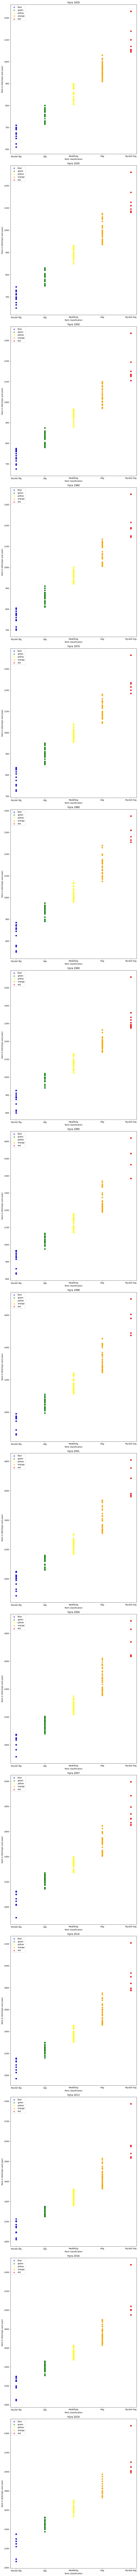

In [24]:
# Klassificera hyresnivåerna för alla värdeår och lägg till kolonner för resultatet i DataFramen från den inlästa CSV-filen från Skatteverket
# Visualisera resultatet
# X-axel: Hyresnivå-klassificering (kan även vara värdeår, men då blir diagrammet en rak vertikal linje)
# Y-axel: Årshyra per kvadratmeter
# Färg: Hyresnivå-klassificering

import matplotlib.pyplot as plt
import pandas
import numpy as np

valueYears = [1929, 1930, 1950, 1960, 1970, 1980, 1990, 1995, 1998, 2001, 2004, 2007, 2010, 2013, 2016, 2019]

# Definierade gränser och klasser för hyres-nivåer
ranges = [10, 35, 65, 90]
rentLevels = ['Mycket låg', 'Låg', 'Medelhög', 'Hög', 'Mycket hög']

def GetRentPerYearPerSqmColumn(builtYear, X):
    if(builtYear <= 1929):
        return skvData['vardear 1929']
    elif(builtYear >= 1930 and builtYear < 1950):
        return skvData['vardear 1930']
    elif(builtYear >= 1950 and builtYear < 1960):
        return skvData['vardear 1950']
    elif(builtYear >= 1960 and builtYear < 1970):
        return skvData['vardear 1960']
    elif(builtYear >= 1970 and builtYear < 1980):
        return skvData['vardear 1970']
    elif(builtYear >= 1980 and builtYear < 1990):
        return skvData['vardear 1980']
    elif(builtYear >= 1990 and builtYear < 1995):
        return skvData['vardear 1990']
    elif(builtYear >= 1995 and builtYear < 1998):
        return skvData['vardear 1995']
    elif(builtYear >= 1998 and builtYear < 2001):
        return skvData['vardear 1998']
    elif(builtYear >= 2001 and builtYear < 2004):
        return skvData['vardear 2001']
    elif(builtYear >= 2004 and builtYear < 2007):
        return skvData['vardear 2004']
    elif(builtYear >= 2007 and builtYear < 2010):
        return skvData['vardear 2007']
    elif(builtYear >= 2010 and builtYear < 2013):
        return skvData['vardear 2010']
    elif(builtYear >= 2013 and builtYear < 2016):
        return skvData['vardear 2013']
    elif(builtYear >= 2016 and builtYear < 2019):
        return skvData['vardear 2016']
    else:
        return skvData['vardear 2019']
    
def GetRentLevel(rentRanges, rentPerSqm):
    level = None
    #print(f'GetRentLevel: {rentRanges}')
    for i, value in enumerate(rentRanges):
        if(rentPerSqm <= value):
            #print(f'rentPerSqm <= value: {value}')
            level = rentLevels[i]
            break

    if(level is None):
    # Hyran var alltså inte lägre än någon av gränsvärdena, alltså tillhör den de högsta 10% av hyror
        #print(f'Det var en hög hyra!')
        level = rentLevels[len(rentLevels)-1]

    return level

def CalculateRentRanges(dataColumn):
    rentLimits = []
    for i, value in enumerate(ranges):
        rentLimits.append(dataColumn.quantile(value/100))
    #print(rentLimits)
    return rentLimits

def ClassifyRent(builtYear, rentPerSqm, rentRanges):
    # Jämför hyran för givet värdeår med hyresnivån i riket
    #print(f'ValueYear:  {builtYear}, RentRanges: {rentRanges}')
    rentLevel = GetRentLevel(rentRanges, rentPerSqm)

    return rentLevel

def GetRentClassificationColumnForValueYear(valueYear, column, rentRanges):
    classificationList = []
    for sqmYearlyRent in column:
        classification = ClassifyRent(valueYear, sqmYearlyRent, rentRanges)
        classificationList.append(classification)
    #print(classificationList)
    return classificationList

skvData = pandas.read_csv('Data/SKV_Genomsnittshyra_bostad_2022-2024.csv')

for valueYear in valueYears:
    #print(valueYear)    
    column = GetRentPerYearPerSqmColumn(valueYear, skvData)
    rentRanges = CalculateRentRanges(column)
    skvData.loc[:, f'Rent Level {valueYear}'] = GetRentClassificationColumnForValueYear(valueYear, skvData[f'vardear {valueYear}'], rentRanges)
    skvData.loc[:, f'{valueYear}'] = [valueYear] * len(skvData)
#print(skvData['Rent Level 1929'])

# Definiera presentations-variabler
rent = "Hyra"

# Match rent-level to a color
colors = {
    'Mycket låg': 'blue',
    'Låg': 'green',
    'Medelhög': 'yellow',
    'Hög': 'orange',
    'Mycket hög': 'red',
}

# Create a plot showing the calculated rent levels and the yearly sqm rents
fig, axes = plt.subplots(nrows=len(valueYears), figsize=(10, 184))
    
for ax, data, valueYear in zip(axes, [skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData, skvData], valueYears):
    for rentLevel, color in colors.items():
        # Filter data by rentLevel
        rentLevelData = data[data[f'Rent Level {valueYear}'] == rentLevel]

        # Plot data
        # ax.scatter(rentLevelData[f'{valueYear}'], rentLevelData[f'vardear {valueYear}'], c=color, label=color, alpha=0.5)
        ax.scatter(rentLevelData[f'Rent Level {valueYear}'], rentLevelData[f'vardear {valueYear}'], c=color, label=color, alpha=0.5)

    ax.set_title(f'{rent} {valueYear}')
    #ax.set_xlabel("Value year")
    ax.set_xlabel("Rent classification")
    ax.set_ylabel("Rent in SEK/(Sqm and year)")
    ax.legend()

plt.tight_layout()
plt.show()

Testa resultatet

Eftersom det är jag som har klassificerat hyresnivåerna samt tar fram värdeåret så har jag ingen "sanning" att kontrollera emot. Därför är testet nedanför inte givande och utkommenterat.

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Kör testet på testdata från Skatteverket
# # Test Scenario 1 där input är hyra, antal kvadratmeter och värdeår
# # sqm_price_X_train, sqm_price_X_test, sqm_price_y_train, sqm_price_y_test = train_test_split(male_X, male_y, test_size = 0.2, random_state= 42
# def GetRentClassificationPerColumn():
#     rentClasses = []
#     for i in sqmForValueYearCol:
#         print(i)
#         r = ClassifyRent(builtYear, i)
#         print(r)
#         rentClasses.append(r)
#     return rentClasses
    
# sqmForValueYearCol = GetRentPerYearPerSqmColumn(builtYear, skvData)
# rentClassifications = GetRentClassificationPerColumn(sqmForValueYearCol)

# x_train, x_test, y_train, y_test = train_test_split(sqmForValueYearCol, rentClassifications, test_size = 0.2, random_state= 42)

# accuracy = accuracy_score(y_test, predictions)

# accuracy